# Lab objective: Analytics Assistant with OpenAI Assistant API

In [2]:
!pip install openai

In [3]:
!pip show openai

Name: openai
Version: 1.26.0
Summary: The official Python library for the openai API
Home-page: 
Author: 
Author-email: OpenAI <support@openai.com>
License: 
Location: C:\Users\vikas_u1mfwb3\AppData\Roaming\Python\Python312\site-packages
Requires: anyio, distro, httpx, pydantic, sniffio, tqdm, typing-extensions
Required-by: langchain-openai, llama-index-agent-openai, llama-index-core, llama-index-legacy, pirate-speak


# Importing necessary libraries

In [4]:
import os, time
from io import BytesIO
from PIL import Image
from openai import OpenAI
from IPython.display import display
os.environ["OPENAI_API_KEY"]= "Your openai-api key"

This code interacts with OpenAI's API to upload a data file and create a specialized AI assistant.

1. **Client Initialization**: Initializes the OpenAI client for API interaction, assuming the API key is already configured for authentication.

2. **File Upload**: Uploads the austin_crime.csv file to OpenAI's servers with the purpose set to 'assistants', indicating its use in assisting AI functionalities.

3. **Assistant Creation**: Creates an AI assistant named "Data Analyses Tutor," equipped with a code interpreter tool and linked to the uploaded file, to provide data analysis tutorials and code demonstrations.

In [10]:


# Initialize the OpenAI client with your API key
client = OpenAI()

# Create a file object with the CSV data
file = client.files.create(
    file=open("austin_crime.csv", "rb"),
    purpose='assistants'
)

# Create an assistant using the OpenAI beta API
assistant = client.beta.assistants.create(
    name="Data Analyses Tutor",
    instructions="You are my personal data analyses tutor. You will help me analyze data and derive insights from it. Show me the code of your analyses.",
    tools=[{"type": "code_interpreter"}],
    model="gpt-4-1106-preview",
    file_ids=[file.id]
)


In this below script, a thread is created to facilitate interaction with an AI assistant. The user inputs a question about a dataset on crime incidents in Austin, and the script processes this input through the AI to provide insights and potentially visual outputs.

1. **Creating a Thread**: The code starts by setting up a new thread. Think of a thread as a conversation or a session where you can ask questions and get responses. It's a space where the interaction with the AI takes place.

2. **Getting User Input**: It then asks you to type a question or request related to a dataset about crime incidents in Austin. Whatever you type is treated as your input for analysis.

3. **Sending the Input to the AI**: Your question is sent to the AI within this thread. This is like you're passing a note to the AI with your question written on it.

4. **Running the AI's Analysis**: Once the AI receives your question, it starts working on it. The code checks repeatedly (every few seconds) to see if the AI is done with your request. This is similar to checking your watch while waiting for a friend to finish a task.

5. **Retrieving and Displaying Results**: When the AI finishes analyzing the data, the results are collected. These results include any insights the AI found from the dataset.

In [11]:
# Create a new thread for interacting with the AI assistant
thread = client.beta.threads.create()

# Prompt for user input regarding what analysis they want to perform on the dataset
user_input = input("Type what would you like to know or analyze about this dataset: ")
print('\n')  # Print a newline for better readability

# Create a message in the thread with the user's query as content
message = client.beta.threads.messages.create(thread_id=thread.id, role="user", content=user_input)

# Create a run to process the user's query using the assistant
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
    instructions=""
)
print(run)  # Print initial run details

# Loop to check the status of the run until it is completed
while run.status != "completed":
    run = client.beta.threads.runs.retrieve(
        thread_id=thread.id,
        run_id=run.id
    )
    time.sleep(3)  # Pause the loop for 3 seconds before checking the status again
    print(run.status)  # Print the current status of the run

# List all messages in the thread to display the results of the run
messages = client.beta.threads.messages.list(thread_id=thread.id)


Type what would you like to know or analyze about this dataset: Do you see any correlation between types of crimes, locations and times? You can also plot graphs for better understanding.


Run(id='run_4kHQuaaXyOVhwr6Az1OSeD0i', assistant_id='asst_WrvooTPEwCAQyvUpthOdXI3i', cancelled_at=None, completed_at=None, created_at=1715514764, expires_at=1715515364, failed_at=None, file_ids=['file-k0cncj2wi79UvhkGVCCwOOun'], instructions='You are my personal data analyses tutor. You will help me analyze data and derive insights from it. Show me the code of your analyses.', last_error=None, metadata={}, model='gpt-4-1106-preview', object='thread.run', required_action=None, started_at=None, status='queued', thread_id='thread_1oIT7LuHnvW7B8Ci9TAMUKCX', tools=[ToolAssistantToolsCode(type='code_interpreter')], usage=None, temperature=1.0, top_p=1.0, max_completion_tokens=None, max_prompt_tokens=None, truncation_strategy={'type': 'auto', 'last_messages': None}, incomplete_details=None, response_format

This script handles the output and cleanup after the AI assistant has processed the user's query. Here's a breakdown:

1. **Displaying Results**: The code iterates through all messages in the thread. It checks each message to see if it's from the current session by matching the run ID. For each relevant message:

If the message content is text (like insights or answers), it prints out the text.
If the message contains an image (like a chart or graph), it retrieves the image file using its file ID, converts it to a displayable format if necessary, saves it locally, and then displays the image.

2. **Deleting Assistant's File**: Once the processing is complete, the code deletes the file associated with the AI assistant. This is a cleanup step to remove any data files that were temporarily uploaded for the assistant to analyze.

3. **Deleting the Assistant**: Finally, the code deletes the AI assistant itself. This is another cleanup step, ensuring that all resources used during the session are properly disposed of once they're no longer needed.

It seems that all the time values in the dataset are `00:00:00`, which implies that we don't have granularity beyond the date for when the crimes occurred. This uniform time is likely either a placeholder or indicates that the specific times of the crimes were not recorded. As such, with this dataset, we won't be able to analyze correlations with specific times of day.

Nevertheless, we can still investigate correlations between types of crimes and locations by using the available spatial data. Let's proceed by looking at the distribution of different types of crimes across the most common locations. Given that we have both 'address' and 'location_description' columns, we will focus on the one that gives us more consistent location information.

Let's first plot the distribution of crimes for the top addresses and location descriptions.


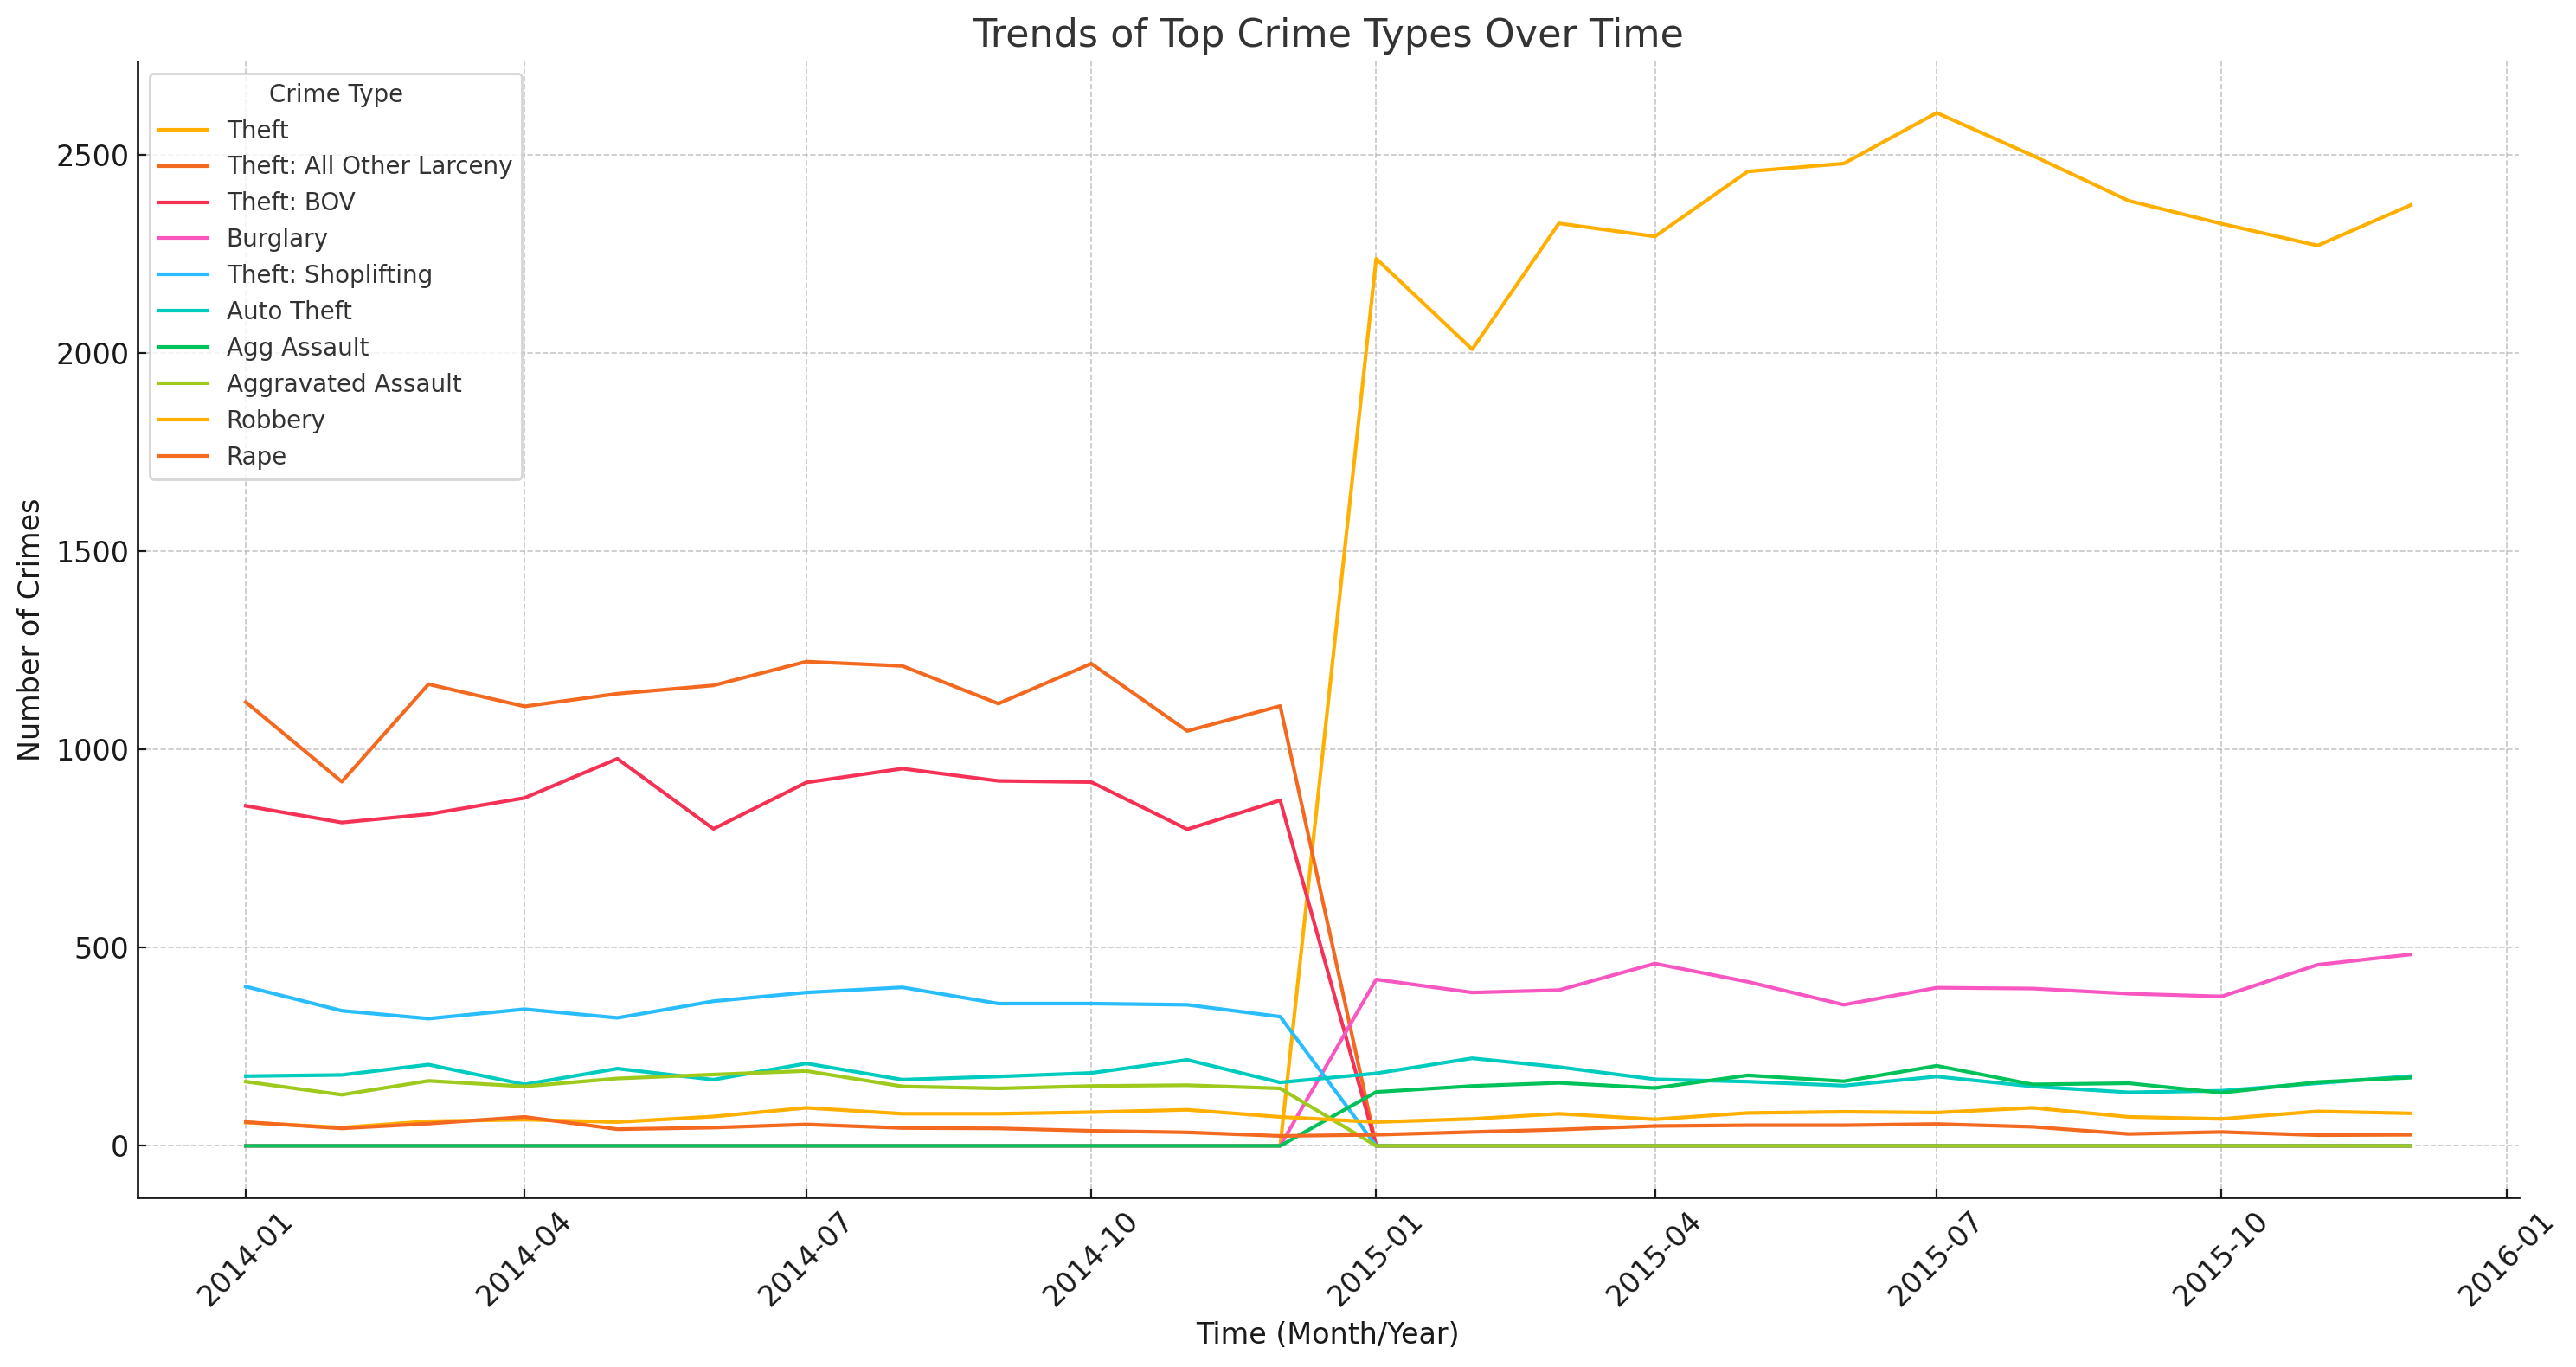

The `crimes_by_month_clean` DataFrame appears correctly structured with `int64` types for all crime count columns, and it contains numeric values with no obvious non-numeric issues. However, there seem to be a large number of 0's in the data, which might be causing issues.

Let's try a different approach for plotting to see if we can circumvent this issue. Instead of using Seaborn directly, let's try plotting with matplotlib and see if this resolves the issue. We will plot the trends for each crime type one by one.
It appears that there is a type error while trying to plot the data. This could indicate that there are non-numeric values in the data or that the plot function is interpreting the data incorrectly. This requires further investigation to determine the cause and resolve it. 

One approach to this problem is to ensure the grouping by `month_year` and `primary_type_clean` results in a DataFrame of numeric values appropriate for plotting. Let's verify the types and contents of t

In [12]:
# Loop through all messages retrieved from the thread
for message in messages.data:
    # Skip messages not associated with the current run
    if message.run_id != run.id:
        continue
    # Check if the message contains text and print it
    if message.content[0].type == "text":
        print(message.content[0].text.value)
    # Check if the message contains an image file
    elif message.content[0].type == "image_file":
        # Retrieve the image file using its file ID
        response_file = client.files.with_raw_response.content(message.content[0].image_file.file_id)
        # Load the image content into a BytesIO stream
        bytes_io = BytesIO(response_file.content)
        # Open the image using PIL
        image = Image.open(bytes_io)
        # Convert the image to RGB if it's in RGBA format
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        # Save the image locally
        image.save("output_image.jpg")
        # Display the image
        display(image)

# Delete the file associated with the assistant from OpenAI's servers
deleted_assistant_file = client.beta.assistants.files.delete(
    assistant_id=assistant.id,
    file_id=file.id
)
# Print the result of the file deletion
print(deleted_assistant_file)

# Delete the assistant itself to clean up resources
response = client.beta.assistants.delete(assistant.id)
# Print the response from attempting to delete the assistant
print(response)
